# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hnc_Ng import  HNC_solver
from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Setting up HNC 

In [2]:
def set_hnc(n_in_per_cc, T, Z, A, Zstar, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='kryov', add_bridge=False, bridge='yukawa',
            pseudopotential=False, r_c=0.6, no_coupling=False, N_bins = 500, R_max=5):
    
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, T, T, ri, Zstar*n_in_AU, which_Tij=which_Tij, r_c=r_c)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = np.array([qsp.Ti, qsp.Te_c])
    masses= np.array([qsp.m_i, m_e])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses ,
                     kappa_multiscale=5, R_max=R_max, N_bins=N_bins, 
                      names=names, dst_type=3, oz_method=oz_type)

    if pseudopotential==True:
        βvei = qsp.βvei_atomic(hnc1.r_array)
    else:
        βvei = qsp.βvei(hnc1.r_array)
    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), βvei],
                            [βvei, qsp.βvee(hnc1.r_array)]])
    if no_coupling:
        βu_r_matrix[0,1]=0
        βu_r_matrix[1,0]=0
    
    if add_bridge:
        if bridge=='ocp':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
        elif bridge=='yukawa':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()

    return hnc1, qsp

In [17]:
mixture_file = "/home/zach/plasma/hnc/data/TCCW_single_species_data.csv"
tccw_mixture_data = read_csv(mixture_file)
tccw_cases = [tccw_mixture_data.iloc[n] for n in range(len(tccw_mixture_data))]

cases_converged_thusfar = {'H1':True,'C1':True, 'Al1':True, 'Cu1': True, 'Be1': True, 'Au1': False, 'H2': True, 'H3': True, 'C2': False, 'C3': True, 'Al2': False, 'Al3': True,
 'Cu2': False, 'Cu3': True, 'H11': False, 'H21': False, 'H31': False, 'C11': False, 'C21': False, 'C31': False, 'Al11': False, 'Al21': False, 
 'Al31': False, 'Cu11': False, 'Cu21': False, 'Cu31': False, 'H12': True, 'H22': True, 'H32': False, 'C12': True, 'C22': False, 'C32': False, 
 'Al12': True, 'Al22': False, 'Al32': False, 'Cu12': True, 'Cu22': False, 'Cu32': False, 'H13': True, 'H23': True, 'H33': True, 'C13': True,
  'C23': True, 'C33': False, 'Al13': False, 'Al23': False, 'Al33': False, 'Cu13': True, 'Cu23': False, 'Cu33': False, 'H14': False, 'H24': False, 
  'H34': False, 'C14': False, 'C24': False, 'C34': False, 'Al14': False, 'Al24': False, 'Al34': False, 'Cu14': False, 'Cu24': False, 'Cu34': False,
   'H15': False, 'H25': False, 'H35': False, 'C15': False, 'C25': False, 'C35': False, 'Al15': False, 'Al25': False, 'Al35': False, 'Cu15': False,
    'Cu25': False, 'Cu35': False, 'H16': False}


cases_zero_Zbar = ['C3','Al3','Cu3','Cu11','Cu12']
cases_no_Zbar = ['H14', 'H24','H34', 'C14', 'C24', 'C34', 'Al14', 'Al24', 'Al34', 'Cu14', 'Cu24', 'Cu34',
   'H15', 'H25', 'H35', 'C15', 'C25', 'C35', 'Al15', 'Al25', 'Al35', 'Cu15',
    'Cu25', 'Cu35', 'H16']

cases_to_plot = cases_converged_thusfar 
for case in cases_zero_Zbar:
    cases_to_plot.pop(case)
for case in cases_no_Zbar:
    cases_to_plot.pop(case)

    

Zstar_dict={}
Te_dict={}
θ_dict={}
rs_dict={}
Z_dict={}
Γii_dict={}
Λei_dict = {}
vei_strength_dict = {}
for  tccw_case in tccw_cases:    
    α = 0.1
    case_converged=False
    case_attempts=0
    case_num= tccw_case[' ']
    case_id = tccw_case['Case ID']
    if case_id in cases_converged_thusfar and case_id not in cases_zero_Zbar:# Only do ones with data, Zbar
        print(case_id)
        ni = tccw_case['Number Density [N/cc]']
        Te = tccw_case['Temperature [eV]']*eV
        Ti = Te
        Z = tccw_case['Atomic Number']
        Zstar = tccw_case['Zbar (TFDW)']
        A = tccw_case['Atomic Weight [a.u.]']
        r_s = tccw_case['Wigner-Seitz Radius [cm]']
        r_c = tccw_case['Average-Bound Radius [cm]']/r_s

        atom, qsp = set_hnc(ni, Te, Z, A, Zstar, 
                                pseudopotential=True, oz_type='svt',r_c=r_c, 
                                add_bridge=True, bridge='ocp', N_bins=100, R_max=3)

        Zstar_dict[case_id]=Zstar
        Te_dict[case_id]=Te
        θ_dict[case_id]=qsp.θ
        rs_dict[case_id]=1e-2*r_s/aB
        Z_dict[case_id]=Z
        Γii_dict[case_id]=qsp.Γii
        Λei_dict[case_id]=qsp.Λei
        vei_strength_dict[case_id]= np.max(np.abs(atom.βu_r_matrix[0,1]))

H1
Λei = 0.355
Λee = 0.502
Λei adjusted with R = 0.355
Γii=5.949, Γie=-0.858, Γee=1.100 
r_i=1.391
r_e=1.512
r_c=0.371
θ  =9.12e-02
C1
Λei = 0.221
Λee = 0.312
Λei adjusted with R = 0.221
Γii=113.495, Γie=-1.589, Γee=0.453 
r_i=1.476
r_e=0.971
r_c=0.284
θ  =3.77e-02
Al1
Λei = 0.231
Λee = 0.326
Λei adjusted with R = 0.231
Γii=62.909, Γie=-2.630, Γee=1.000 
r_i=2.989
r_e=2.166
r_c=0.218
θ  =9.36e-02
Cu1
Λei = 0.186
Λee = 0.263
Λei adjusted with R = 0.186
Γii=301.565, Γie=-3.156, Γee=0.580 
r_i=2.667
r_e=1.517
r_c=0.199
θ  =4.59e-02
Be1
Λei = 0.258
Λee = 0.365
Λei adjusted with R = 0.258
Γii=7.797, Γie=-1.703, Γee=0.988 
r_i=2.357
r_e=1.966
r_c=0.267
θ  =3.39e-01
Au1
Λei = 0.153
Λee = 0.216
Λei adjusted with R = 0.153
Γii=58.793, Γie=-3.556, Γee=0.441 
r_i=3.010
r_e=1.501
r_c=0.155
θ  =4.49e-01
H2
Λei = 0.353
Λee = 0.500
Λei adjusted with R = 0.353
Γii=437.642, Γie=-0.231, Γee=0.235 
r_i=0.300
r_e=0.302
r_c=0.530
θ  =3.63e-04
H3
Λei = 0.345
Λee = 0.488
Λei adjusted with R = 0.345
Γii=1.830

In [4]:
import matplotlib.patches as mpatches

def TwoParameter_Plot(param_1,param_2, truth_values, param=["",""]):
#     param_1 = {'case 1' : 1, 'case 2': 2, 'case 3': 3, 'case 4': 4, 'case 5': 5}
#     param_2 = {'case 1' : 5, 'case 2': 4, 'case 3': 3, 'case 4': 2, 'case 5': 1}
#     truth_values = {'case 1': True, 'case 2': False, 'case 3': True, 'case 4': False, 'case 5': True}

    # we assume that all three dictionaries have the same keys
    assert param_1.keys() == param_2.keys() == truth_values.keys()

    # convert truth values to colors
    color_map = {True: 'k', False: 'r'} # True -> red, False -> blue
    colors = [color_map[truth_values[case]] for case in param_1.keys()]

    fig, ax = plt.subplots(figsize=(8,6))
    fig.suptitle("Cases Converged", fontsize=20)
    scatter = ax.scatter(list(param_1.values()), list(param_2.values()), c=colors)

    # specify labels
    ax.set_xlabel(param[0], fontsize=15)
    ax.set_ylabel(param[1], fontsize=15)
    ax.tick_params(labelsize=15)
    
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    red_patch = mpatches.Patch(color='k', label='True')
    blue_patch = mpatches.Patch(color='r', label='False')
    plt.legend(handles=[red_patch, blue_patch])


    plt.show()

# Zbar vs Z

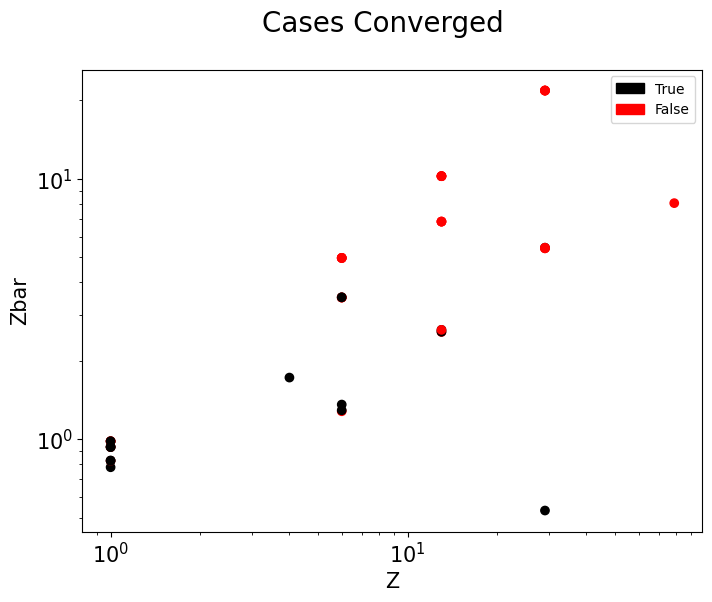

In [22]:
TwoParameter_Plot(Z_dict, Zstar_dict, cases_converged_thusfar,param=['Z','Zbar'])

# θ vs Γ

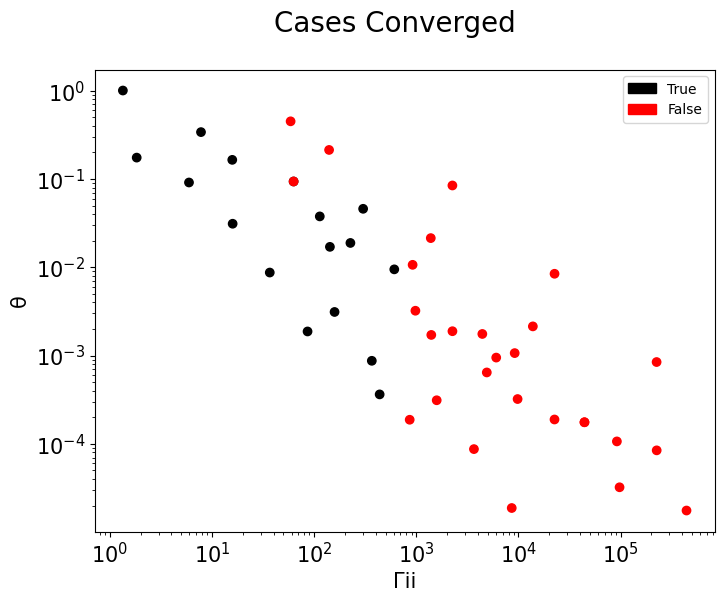

In [6]:
TwoParameter_Plot(Γii_dict, θ_dict, cases_converged_thusfar, param=['Γii','θ'])

# Te vs rs

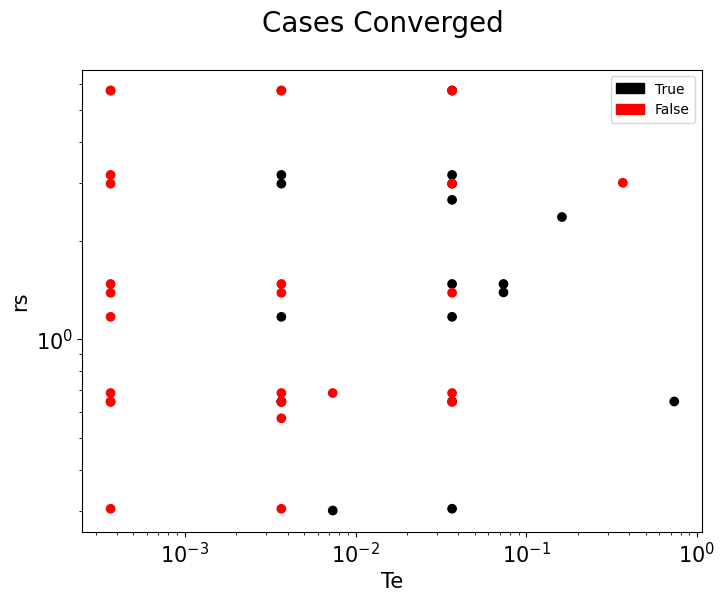

In [7]:
TwoParameter_Plot(Te_dict, rs_dict, cases_converged_thusfar, param=['Te','rs'])

# Λ vs Γ

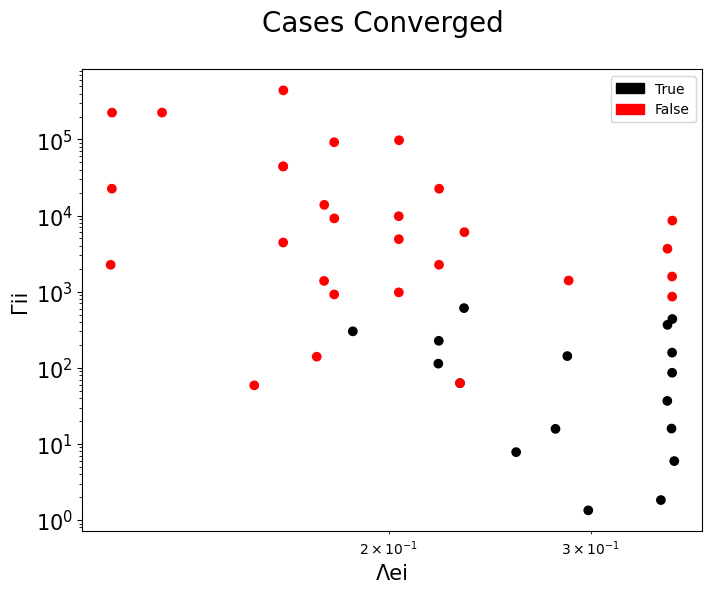

In [13]:
TwoParameter_Plot(Λei_dict, Γii_dict, cases_converged_thusfar, param=['Λei','Γii'])

# βvei Strength vs Γii

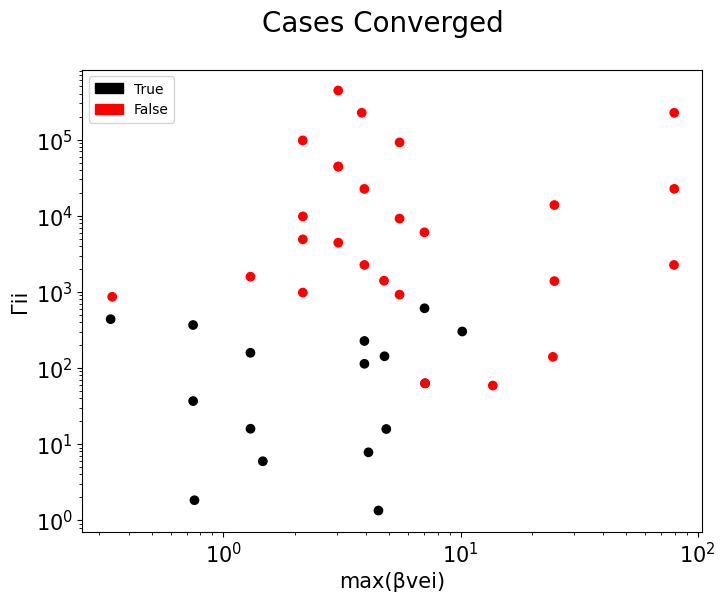

In [20]:
TwoParameter_Plot(vei_strength_dict, Γii_dict, cases_converged_thusfar, param=['max(βvei)','Γii'])

# Z vs Te

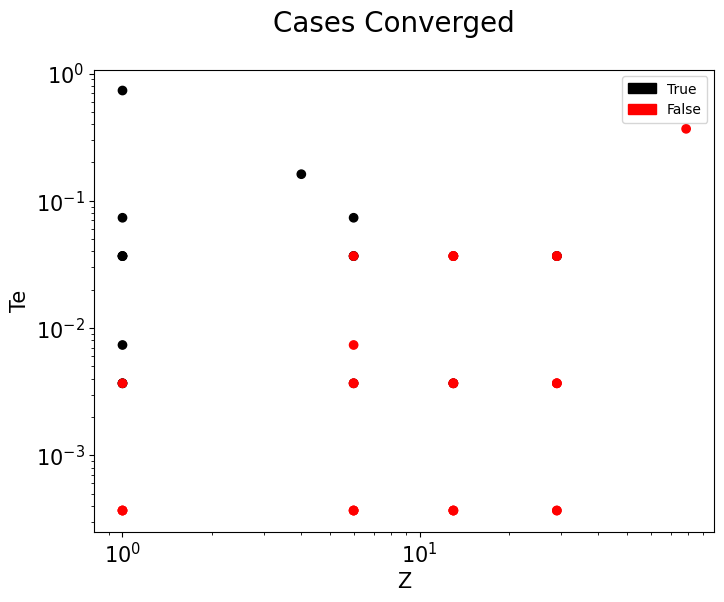

In [21]:
TwoParameter_Plot(Z_dict, Te_dict, cases_converged_thusfar,param=['Z','Te'])

# Z vs Γii

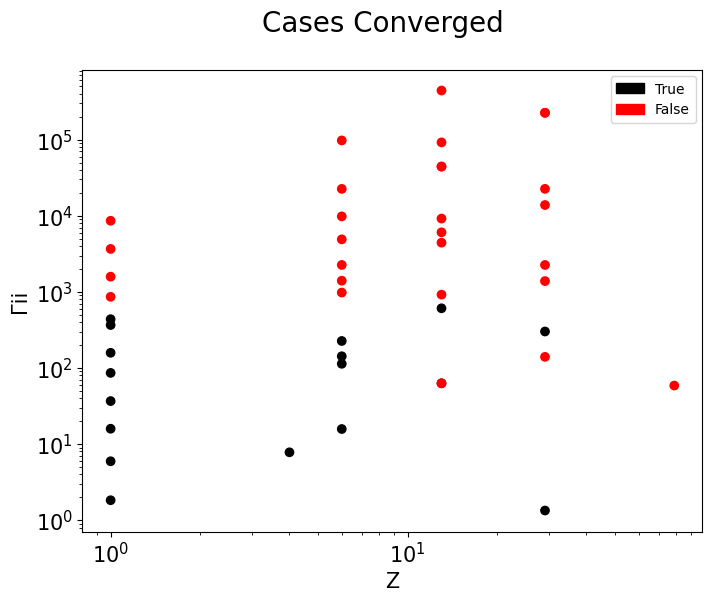

In [24]:
TwoParameter_Plot(Z_dict, Γii_dict, cases_converged_thusfar,param=['Z','Γii'])